## Data Overview & Quality Assessment

### MIMIC-III (10,000 Patients Extract)

MIMIC-III (Medical Information Mart for Intensive Care) is a publicly available database containing deidentified health-related data for ICU patients. This database consists of 26 tables and includes information about over forty thousand patients who stayed in critical care units at the Beth Israel Deaconess Medical Center between 2001 and 2012. The data encompasses demographics, laboratory test results, procedures, medications, caregiver notes, and imaging reports.

This notebook provides:
- Overview of each table used in analysis  
- Dimensions, missingness, data types  
- Key integrity checks (SUBJECT_ID, HADM_ID, ICUSTAY_ID)  
- Basic descriptive statistics  
- Joining strategy for downstream tasks  
- Identification of usable variables for ML and BI dashboards

#### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

#### Loading Core Tables

In [2]:
DATA_PATH = "Data/"

tables = {
    "PATIENTS": "PATIENTS_sorted.csv",
    "ADMISSIONS": "ADMISSIONS_sorted.csv",
    "ICUSTAYS": "ICUSTAYS_sorted.csv",
    "LABEVENTS": "LABEVENTS_sorted.csv",
    "DIAGNOSES_ICD": "DIAGNOSES_ICD_sorted.csv",
    "INPUTEVENTS_MV": "INPUTEVENTS_MV_sorted.csv",
    "OUTPUTEVENTS": "OUTPUTEVENTS_sorted.csv",
    "NOTEEVENTS": "NOTEEVENTS_sorted.csv",
    "PRESCRIPTIONS": "PRESCRIPTIONS_sorted.csv",
    "PROCEDURES_ICD": "PROCEDURES_ICD_sorted.csv"
}

In [3]:
data = {}
for name, file in tables.items():
    try:
        df = pd.read_csv(DATA_PATH + file, low_memory=False)
        data[name] = df
        print(f"{name:20s} Loaded — {df.shape[0]:,} rows × {df.shape[1]:,} columns")
    except:
        print(f"⚠ Could not load {file}")

PATIENTS             Loaded — 10,000 rows × 8 columns
ADMISSIONS           Loaded — 12,911 rows × 19 columns
ICUSTAYS             Loaded — 13,436 rows × 12 columns
LABEVENTS            Loaded — 6,612,626 rows × 9 columns
DIAGNOSES_ICD        Loaded — 118,300 rows × 5 columns
INPUTEVENTS_MV       Loaded — 2,076,226 rows × 31 columns
OUTPUTEVENTS         Loaded — 1,152,258 rows × 13 columns
NOTEEVENTS           Loaded — 482,770 rows × 11 columns
PRESCRIPTIONS        Loaded — 1,025,065 rows × 19 columns
PROCEDURES_ICD       Loaded — 58,969 rows × 5 columns


#### Rows from the Core Tables

In [4]:
for name, df in data.items():
    print(f"\n===== {name} =====")
    display(df.head())


===== PATIENTS =====


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,1,2,M,2138-07-17 00:00:00,NaN,NaN,NaN,0
1,2,3,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1
2,3,4,F,2143-05-12 00:00:00,NaN,NaN,NaN,0
3,4,5,M,2103-02-02 00:00:00,NaN,NaN,NaN,0
4,5,6,F,2109-06-21 00:00:00,NaN,NaN,NaN,0



===== ADMISSIONS =====


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1



===== ICUSTAYS =====


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,1,2,163353,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918
1,2,3,145834,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
2,3,4,185777,294638,carevue,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785
3,4,5,178980,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844
4,5,6,107064,228232,carevue,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729



===== LABEVENTS =====


,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,19,2,163353.0,51137,2138-07-17 21:10:00,1+,NaN,NaN,NaN
1,21,2,163353.0,51144,2138-07-17 21:10:00,1,1.0,%,NaN
2,22,2,163353.0,51146,2138-07-17 21:10:00,0,0.0,%,NaN
3,23,2,163353.0,51200,2138-07-17 21:10:00,0,0.0,%,NaN
4,24,2,163353.0,51221,2138-07-17 21:10:00,49.6,49.6,%,NaN



===== DIAGNOSES_ICD =====


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1,2,163353,1.0,V3001
1,2,2,163353,2.0,V053
2,3,2,163353,3.0,V290
3,12,3,145834,9.0,2639
4,10,3,145834,7.0,6826



===== INPUTEVENTS_MV =====


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,RATEUOM,STORETIME,CGID,ORDERID,LINKORDERID,ORDERCATEGORYNAME,SECONDARYORDERCATEGORYNAME,ORDERCOMPONENTTYPEDESCRIPTION,ORDERCATEGORYDESCRIPTION,PATIENTWEIGHT,TOTALAMOUNT,TOTALAMOUNTUOM,ISOPENBAG,CONTINUEINNEXTDEPT,CANCELREASON,STATUSDESCRIPTION,COMMENTS_EDITEDBY,COMMENTS_CANCELEDBY,COMMENTS_DATE,ORIGINALAMOUNT,ORIGINALRATE
0,1006655,23,124321,234044.0,2157-10-22 08:39:00,2157-10-22 09:24:00,222042,2.404798,mg,0.799999,mcg/kg/min,2157-10-22 08:43:00,19907,9637800,823462,01-Drips,02-Fluids (Crystalloids),Main order parameter,Continuous Med,66.8,250.0,ml,0,0,0,Changed,NaN,NaN,NaN,95.443741,0.800
1,1006623,23,124321,234044.0,2157-10-22 09:48:00,2157-10-22 10:45:00,222042,1.142198,mg,0.299978,mcg/kg/min,2157-10-22 09:52:00,19907,2751868,823462,01-Drips,02-Fluids (Crystalloids),Main order parameter,Continuous Med,66.8,250.0,ml,0,0,0,Stopped,NaN,NaN,NaN,92.237457,0.300
2,1006622,23,124321,234044.0,2157-10-22 02:33:00,2157-10-22 08:39:00,225158,48.890705,ml,8.014870,mL/hour,2157-10-22 03:48:00,19050,2527673,823462,01-Drips,02-Fluids (Crystalloids),Mixed solution,Continuous Med,66.8,250.0,ml,0,0,0,Changed,NaN,NaN,NaN,239.778200,8.015
3,1006621,23,124321,234044.0,2157-10-22 02:33:00,2157-10-22 08:39:00,222042,24.445354,mg,0.999859,mcg/kg/min,2157-10-22 03:48:00,19050,2527673,823462,01-Drips,02-Fluids (Crystalloids),Main order parameter,Continuous Med,66.8,250.0,ml,0,0,0,Changed,NaN,NaN,NaN,119.889100,1.000
4,1006620,23,124321,234044.0,2157-10-22 00:00:00,2157-10-22 00:01:00,226452,150.000000,ml,NaN,NaN,2157-10-22 00:42:00,19050,2083537,2083537,14-Oral/Gastric Intake,NaN,Main order parameter,Bolus,66.8,150.0,ml,0,0,1,Rewritten,NaN,RN,2157-10-22 00:43:00,150.000000,150.000



===== OUTPUTEVENTS =====


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,VALUE,VALUEUOM,STORETIME,CGID,STOPPED,NEWBOTTLE,ISERROR
0,190984,3,145834.0,211552.0,2101-10-22 17:00:00,40055,160.0,ml,2101-10-22 17:24:00,21570,NaN,NaN,NaN
1,191008,3,145834.0,211552.0,2101-10-23 20:00:00,40055,240.0,ml,2101-10-23 20:22:00,15225,NaN,NaN,NaN
2,191007,3,145834.0,211552.0,2101-10-23 19:30:00,40055,500.0,ml,2101-10-23 19:36:00,15225,NaN,NaN,NaN
3,191006,3,145834.0,211552.0,2101-10-23 18:00:00,40055,500.0,ml,2101-10-23 18:04:00,21570,NaN,NaN,NaN
4,191005,3,145834.0,211552.0,2101-10-23 17:00:00,40055,600.0,ml,2101-10-23 17:10:00,21570,NaN,NaN,NaN



===== NOTEEVENTS =====


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,1678764,2,163353.0,2138-07-17,2138-07-17 22:51:00,2138-07-17 23:12:00,Nursing/other,Report,16929.0,NaN,Neonatology Attending Triage Note\n\nBaby [**N...
1,1678765,2,163353.0,2138-07-17,2138-07-17 23:08:00,2138-07-17 23:18:00,Nursing/other,Report,17774.0,NaN,Nursing Transfer note\n\n\nPt admitted to NICU...
2,272794,3,NaN,2101-10-06,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nInferior/lateral ST-T changes ar...
3,769224,3,145834.0,2101-10-26,2101-10-26 06:01:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2101-10-26**] 6:01 AM\n CHEST (PORTABLE AP)...
4,272793,3,NaN,2101-10-11,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nA-V delay\nNonspecific inferior ...



===== PRESCRIPTIONS =====


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2968761,2,163353,243653.0,2138-07-18 00:00:00,2138-07-20 00:00:00,MAIN,NEO*IV*Gentamicin,NaN,NaN,GENT10I,009298,6.332302e+10,10mg/mL-2mL,15.5,mg,0.775,VIAL,IV
1,2968759,2,163353,243653.0,2138-07-18 00:00:00,2138-07-20 00:00:00,BASE,Syringe (Neonatal) *D5W*,NaN,NaN,NEOSYRD5W,NaN,0.000000e+00,1 Syringe,2.4,ml,2.4,ml,IV
2,2968762,2,163353,243653.0,2138-07-18 00:00:00,2138-07-21 00:00:00,MAIN,Ampicillin Sodium,NaN,NaN,AMP500I,008937,6.332304e+10,500mg Vial,500,mg,1,VIAL,IV
3,2968760,2,163353,243653.0,2138-07-18 00:00:00,2138-07-21 00:00:00,BASE,Send 500mg Vial,NaN,NaN,AMPVL,NaN,0.000000e+00,Send 500mg Vial,1,VIAL,1,VIAL,IV
4,1213835,4,185777,294638.0,2191-03-16 00:00:00,2191-03-23 00:00:00,MAIN,Guaifenesin-Codeine Phosphate,Guaifenesin-Codeine Phosphate,Guaifenesin-Codeine Phosphate,GGAC5L,045667,3.186741e+07,5ML UDCUP,5-10,ml,1-2,UDCUP,PO



===== PROCEDURES_ICD =====


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,109376,2,163353,1,9955
1,44184,3,145834,1,9604
2,44185,3,145834,2,9962
3,44186,3,145834,3,8964
4,44187,3,145834,4,9672


#### Key Summary Table

In [5]:
summary = []

for name, df in data.items():
    summary.append([
        name,
        df.shape[0],
        df.shape[1],
        df.isna().mean().mean(),
    ])

summary_df = pd.DataFrame(summary, columns=["Table", "Rows", "Columns", "Avg Missing (%)"])
summary_df["Avg Missing (%)"] = (summary_df["Avg Missing (%)"] * 100).round(2)
summary_df

,Table,Rows,Columns,Avg Missing (%)
0,PATIENTS,10000,8,25.76
1,ADMISSIONS,12911,19,15.67
2,ICUSTAYS,13436,12,0.01
3,LABEVENTS,6612626,9,12.79
4,DIAGNOSES_ICD,118300,5,0.00
5,INPUTEVENTS_MV,2076226,31,13.69
6,OUTPUTEVENTS,1152258,13,23.43
7,NOTEEVENTS,482770,11,17.68
8,PRESCRIPTIONS,1025065,19,6.57
9,PROCEDURES_ICD,58969,5,0.00


#### Summary Table Visualization

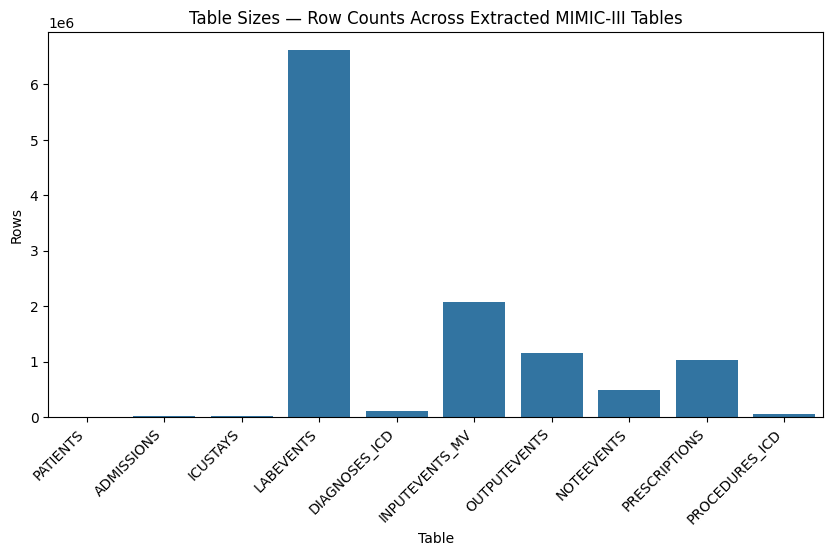

In [6]:
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x="Table", y="Rows")
plt.xticks(rotation=45, ha='right')
plt.title("Table Sizes — Row Counts Across Extracted MIMIC-III Tables")
plt.show()

#### Key Integrity Checks

We need to ensure:
- SUBJECT_ID is valid across tables  
- HADM_ID exists where required  
- ICUSTAY_ID exists in ICU-specific tables  
- No duplicated entries  
- Time columns are correctly formatted  

These steps validate that the dataset is suitable for ML, analytics, and temporal modeling.

#### Duplicates & ID Validation

In [7]:
def check_keys(df, keys):
    missing = [k for k in keys if k not in df.columns]
    if missing:
        print(f"⚠ Missing keys {missing} in table")
    else:
        dup = df.duplicated(keys).sum()
        print(f"✓ Keys {keys} found — {dup} duplicates")

In [8]:
check_keys(data["PATIENTS"], ["SUBJECT_ID"])
check_keys(data["ADMISSIONS"], ["SUBJECT_ID", "HADM_ID"])
check_keys(data["ICUSTAYS"], ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])

✓ Keys ['SUBJECT_ID'] found — 0 duplicates
✓ Keys ['SUBJECT_ID', 'HADM_ID'] found — 0 duplicates
✓ Keys ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'] found — 0 duplicates


#### Convert Time Columns to datetime

In [9]:
time_columns = ["ADMITTIME","DISCHTIME","INTIME","OUTTIME","CHARTTIME","STARTTIME","ENDTIME"]

for name, df in data.items():
    for col in time_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

print("✓ Time columns converted where applicable")

✓ Time columns converted where applicable


#### Missingness Heatmaps

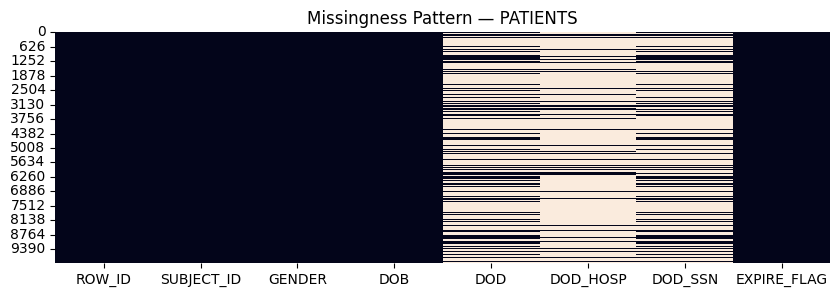

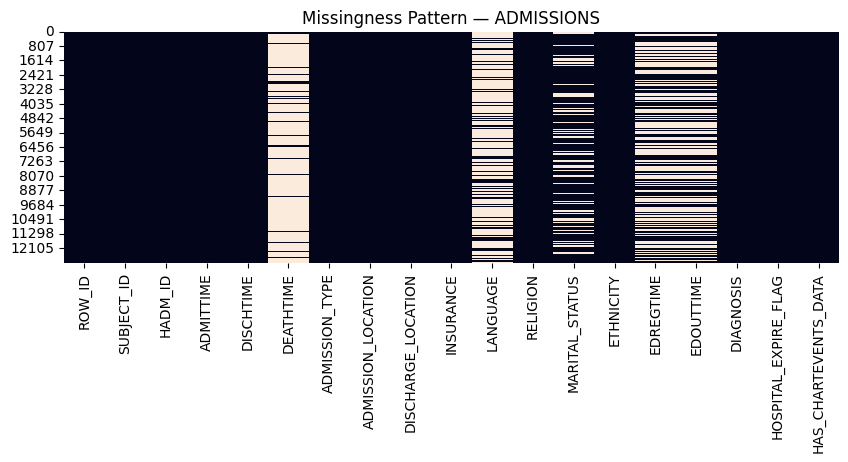

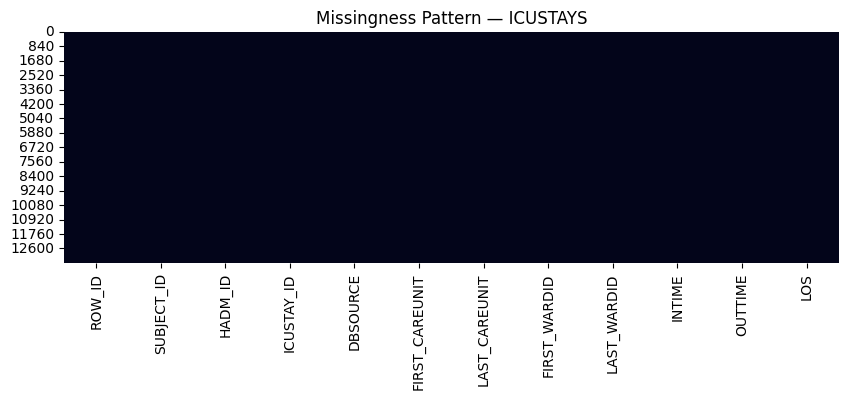

In [10]:
for name in ["PATIENTS", "ADMISSIONS", "ICUSTAYS"]:
    plt.figure(figsize=(10,3))
    sns.heatmap(data[name].isna(), cbar=False)
    plt.title(f"Missingness Pattern — {name}")
    plt.show()

#### Descriptive Statistics

In [11]:
patients = data["PATIENTS"]
admissions = data["ADMISSIONS"]
combined_df = pd.merge(patients, admissions, on="SUBJECT_ID")

In [15]:
combined_df['DOB'] = pd.to_datetime(combined_df['DOB'], errors='coerce')
combined_df['ADMITTIME'] = pd.to_datetime(combined_df['ADMITTIME'], errors='coerce')

combined_df["AGE"] = (combined_df["ADMITTIME"].dt.year - combined_df["DOB"].dt.year).clip(0,110)

In [16]:
combined_df["AGE"].describe()

count    12911.000000
mean        50.596158
std         31.413011
min          0.000000
25%         29.000000
50%         58.000000
75%         74.000000
max        110.000000
Name: AGE, dtype: float64

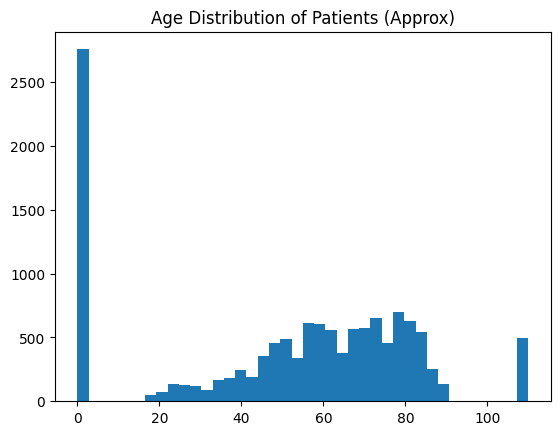

In [17]:
plt.hist(combined_df['AGE'].dropna(), bins=40)
plt.title("Age Distribution of Patients (Approx)")
plt.show()


=== Gender Distribution ===


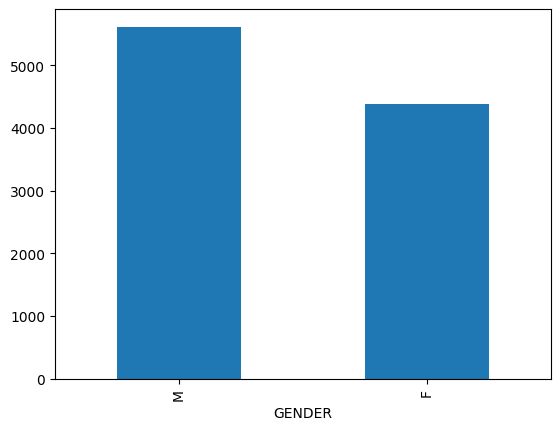

In [18]:
print("\n=== Gender Distribution ===")
patients["GENDER"].value_counts().plot(kind='bar')
plt.show()

#### Admissions Overview

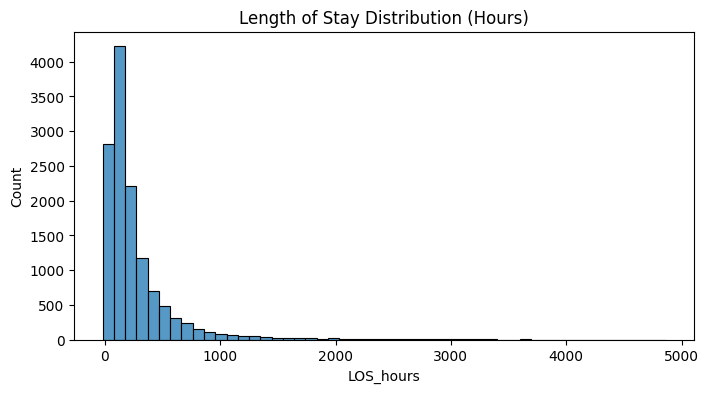

,INSURANCE,ADMISSION_TYPE,ADMISSION_LOCATION
count,12911,12911,12911
unique,5,4,8
top,Medicare,EMERGENCY,EMERGENCY ROOM ADMIT
freq,5598,8319,5597


In [19]:
admissions['LOS_hours'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.total_seconds()/3600
plt.figure(figsize=(8,4))
sns.histplot(admissions['LOS_hours'], bins=50)
plt.title("Length of Stay Distribution (Hours)")
plt.show()

admissions[['INSURANCE','ADMISSION_TYPE','ADMISSION_LOCATION']].describe(include='all')

#### ICU Stay Overview

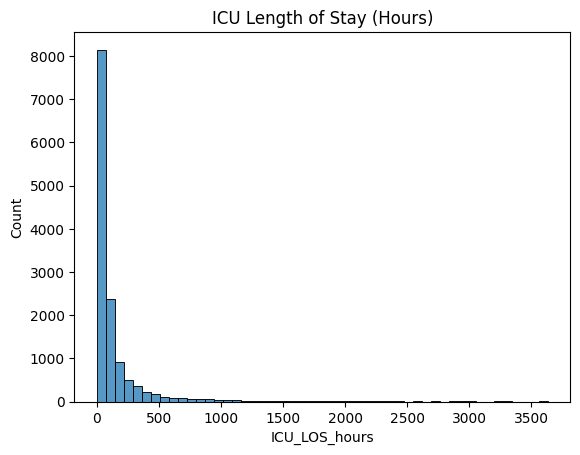

In [20]:
icustays = data["ICUSTAYS"]
icustays["ICU_LOS_hours"] = (icustays["OUTTIME"] - icustays["INTIME"]).dt.total_seconds()/3600

sns.histplot(icustays["ICU_LOS_hours"], bins=50)
plt.title("ICU Length of Stay (Hours)")
plt.show()

#### Lab Events Sample Overview

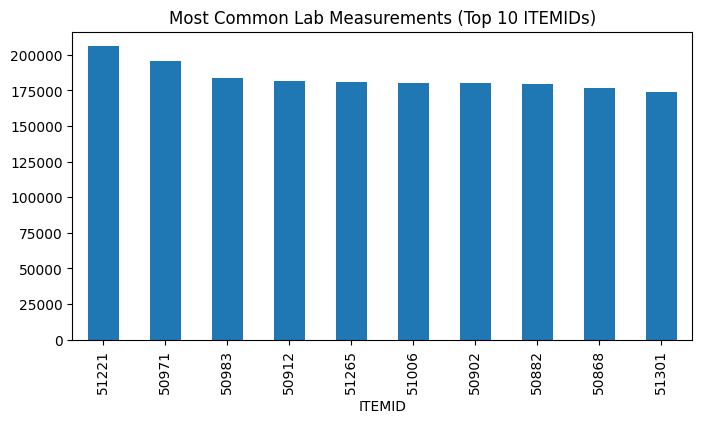

In [21]:
labs = data["LABEVENTS"]
top_labs = labs['ITEMID'].value_counts().head(10)

top_labs.plot(kind='bar', figsize=(8,4))
plt.title("Most Common Lab Measurements (Top 10 ITEMIDs)")
plt.show()

#### Prepare List of Usable Features

##### Variables Selected for Next Steps

Based on availability, completeness, and clinical relevance:

###### Demographics  
- Age  
- Gender  
- Ethnicity  

###### Admissions  
- Admission type  
- Insurance  
- Length of Stay  
- Mortality Flag (HOSPITAL_EXPIRE_FLAG)  

###### ICU Features  
- ICU length of stay  
- First 24h labs (extracted in Notebook 02)  

###### Diagnosis  
- ICD-9 categories (for comorbidity index)  

These will be used in:
- Notebook 02 (Mortality Prediction)
- Notebook 03 (Temporal Analysis)
- Notebook 04 (Treatment Effectiveness)
- Notebook 05 (LOS & Cost Modeling)
- Notebook 06 (Disparity Analysis)

#### Save Cleaned Core Files

In [22]:
core = admissions.merge(patients, on="SUBJECT_ID", how="left")\
                 .merge(icustays, on=["SUBJECT_ID","HADM_ID"], how="left")

core.to_csv("Data/Generated/CORE_MERGED.csv", index=False)
print("✓ Saved cleaned merged core dataset")

✓ Saved cleaned merged core dataset
